## Imports

In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None

import matplotlib.pyplot as plt

import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import tensorflow as tf
import collections

## Data & Preproc

In [2]:
# Load your data
df = pd.read_csv('./data/tilos_hourly.csv')

# Ensure datetime column is in datetime format
df['datetime'] = pd.to_datetime(df['datetime'])

# Set the datetime column as the index
df.set_index('datetime', inplace=True)

# Handle missing values if any
df = df.fillna(method='ffill')  # Forward fill as an example


In [3]:
# Create lag features
for lag in range(1, 25):
    df[f'lag_{lag}'] = df['value'].shift(lag)

# Drop rows with NaN values (due to lagging)
df.dropna(inplace=True)

# Split the data into training and testing sets
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]


In [4]:
import lightgbm as lgb

# Separate features and target
X_train, y_train = train.drop('value', axis=1), train['value']
X_test, y_test = test.drop('value', axis=1), test['value']

# Create LightGBM datasets
dtrain = lgb.Dataset(X_train, label=y_train)
dtest = lgb.Dataset(X_test, label=y_test, reference=dtrain)


## Model Train

In [5]:
# Define the parameters for the LightGBM model
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 31,
    'learning_rate': 0.1,
    'feature_fraction': 0.9
}

# Train the model
bst = lgb.train(params, dtrain, num_boost_round=100, valid_sets=[dtrain, dtest])


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000681 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 3360, number of used features: 24
[LightGBM] [Info] Start training from score 246.145696


## Model Eval

In [6]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Make predictions
preds = bst.predict(X_test, num_iteration=bst.best_iteration)

# Calculate the metrics
mse = mean_squared_error(y_test, preds)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, preds)

# Print the metrics (optional)
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')

# Create a DataFrame to hold the metrics
metrics_df = pd.DataFrame({
    'Metric': ['MSE', 'RMSE', 'MAE'],
    'Value': [mse, rmse, mae]
})

# Save the DataFrame to a CSV file
metrics_df.to_csv('metrics_LGB.csv', index=False)

# Print confirmation (optional)
print('Metrics saved to metrics.csv')


Mean Squared Error (MSE): 688.9406677631423
Root Mean Squared Error (RMSE): 26.247679283379366
Mean Absolute Error (MAE): 16.61902736787184
Metrics saved to metrics.csv


## Plotting

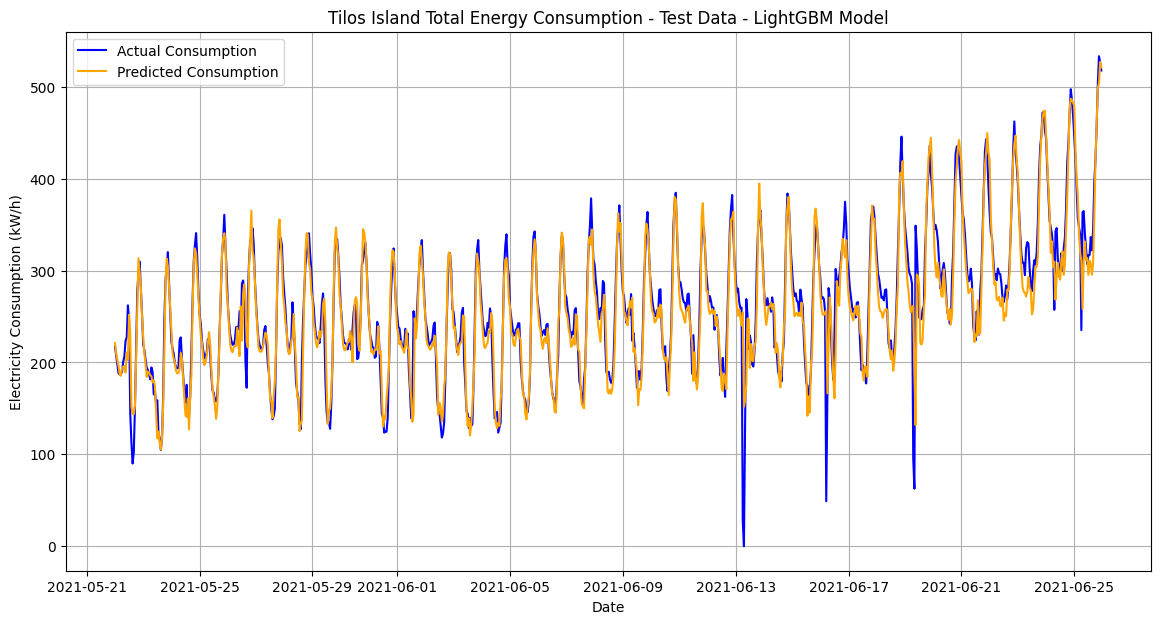

In [7]:
import matplotlib.pyplot as plt

# Create a DataFrame to hold the actual and predicted values
results = pd.DataFrame({'Actual': y_test, 'Predicted': preds}, index=y_test.index)

# Plot the results
plt.figure(figsize=(14, 7))

# Plot actual values
plt.plot(results.index, results['Actual'], label='Actual Consumption', color='blue')

# Plot predicted values
plt.plot(results.index, results['Predicted'], label='Predicted Consumption', color='orange')

# Add title and labels
plt.title('Tilos Island Total Energy Consumption - Test Data - LightGBM Model')
plt.xlabel('Date')
plt.ylabel('Electricity Consumption (kW/h)')

# Show legend
plt.legend()

plt.grid(True)

# Display the plot
plt.show()
